1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.


Global Minimum Found at Initial Guess (1, 1):
Minimum Point: [-0.08984201  0.71265644]
Function Value at Global Minimum: -1.0316284534898628

Global Minimum Found at Initial Guess (0, 0):
Minimum Point: [0. 0.]
Function Value at Global Minimum: 0.0

Global Minimum Found at Initial Guess (1, 0):
Minimum Point: [ 0.08984192 -0.71265586]
Function Value at Global Minimum: -1.031628453487512

Global Minimum Found at Initial Guess (0, 1):
Minimum Point: [-0.08984199  0.71265638]
Function Value at Global Minimum: -1.0316284534898699

Global Minimum Found at Initial Guess (-1, -1):
Minimum Point: [ 0.089842   -0.71265645]
Function Value at Global Minimum: -1.0316284534898554

Global Minimum Found at Initial Guess (-2, -1):
Minimum Point: [ 0.08984199 -0.71265635]
Function Value at Global Minimum: -1.031628453489849


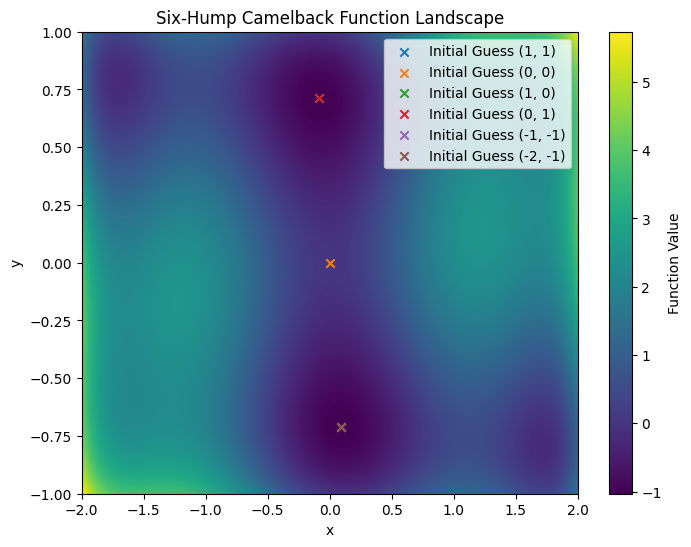

From the analysis above, it can be seen that the function has two global minima. at (-0.08984199,  0.71265638) and (0.08984192, -0.71265586). 
At these points, the function evaluates to (-1.0316284534898554).
Also it can be seen that choosing (0, 0) as an initial guess leads the optimization algorithm to a local minimum which is at (0.00).


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#function for the six hump camelback
def camelback(x):
    return (4 - 2.1 * x[0]**2 + x[0]**4 / 3) * x[0]**2 + x[0] * x[1] + (4 * x[1]**2 - 4) * x[1]**2

# creating the meshgrid
x_range = np.linspace(-2, 2, 400)
y_range = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x_range, y_range)
Z = camelback([X, Y])

# plotting and visualizing the function landscape
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=[-2, 2, -1, 1], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Function Value')
plt.title("Six-Hump Camelback Function Landscape")
plt.xlabel('x')
plt.ylabel('y')

# Finding and ploting the global minima using optimization
initial_guesses = [(1, 1), (0, 0), (1, 0), (0, 1), (-1, -1), (-2, -1)]

for initial_guess in initial_guesses:
    result = minimize(camelback, initial_guess, bounds= [(-2, 2), (-1, 1)])
    
    # Print the results
    print(f"\nGlobal Minimum Found at Initial Guess {initial_guess}:")
    print(f"Minimum Point: {result.x}")
    print(f"Function Value at Global Minimum: {result.fun}")
    
    # Marking the global minimum on the plot
    plt.scatter(result.x[0], result.x[1], label=f'Initial Guess {initial_guess}', marker='x')

plt.legend()
plt.show()

print('''From the analysis above, it can be seen that the function has two global minima. at (-0.08984199,  0.71265638) and (0.08984192, -0.71265586). 
At these points, the function evaluates to (-1.0316284534898554).
Also it can be seen that choosing (0, 0) as an initial guess leads the optimization algorithm to a local minimum which is at (0.00).''')

From the analysis above, it can be seen that the function has two global minima. at (-0.08984199,  0.71265638) and (0.08984192, -0.71265586). At these points, the function evaluates to (-1.0316284534898554).
Also it can be seen that choosing (0, 0) as an initial guess leads the optimization algorithm to a local minimum which is at (0.00).

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

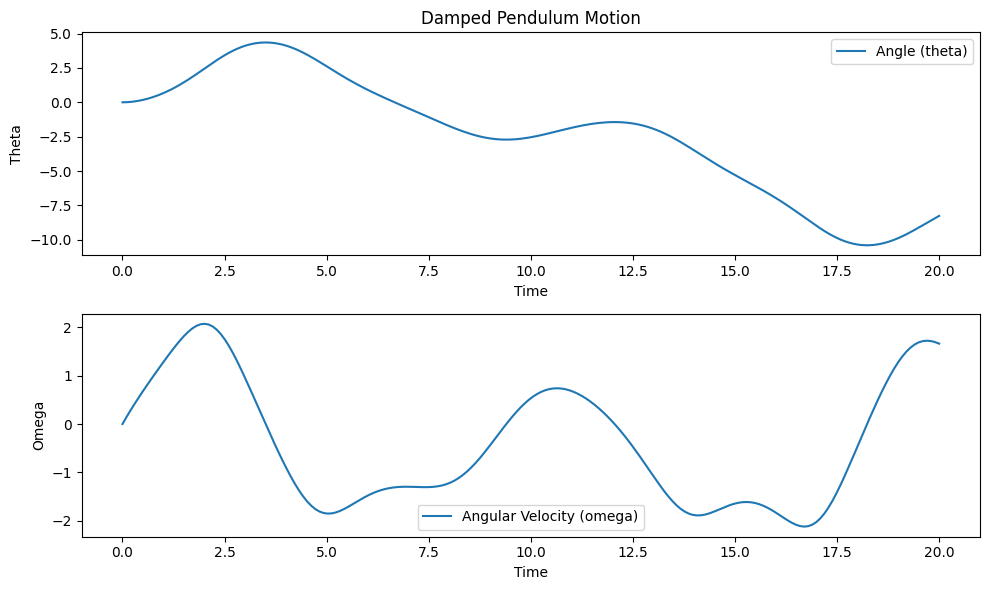

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# defining the function
def pendulum(y, t, Q, g, l, d, Omega):
    theta, omega = y
    dydt = [omega, -omega/Q + (g/l)*np.sin(theta) + d*np.cos(Omega*t)]
    return dydt

# Setting initial conditions and parameters
theta0, omega0 = 0.0, 0.0
initial_conditions = [theta0, omega0]
l, Q, g, d, Omega = 10, 2.0, 9.8, 1.5, 0.65

t = np.linspace(0, 20, 200)

# Solving the ODE using odeint
solution = odeint(pendulum, initial_conditions, t, args=(Q, g, l, d, Omega))

# Extracting the solutions for theta and omega
theta, omega = solution[:, 0], solution[:, 1]

# Plotting the results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, theta, label='Angle (theta)')
plt.title('Damped Pendulum Motion')
plt.xlabel('Time')
plt.ylabel('Theta')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, omega, label='Angular Velocity (omega)')
plt.xlabel('Time')
plt.ylabel('Omega')
plt.legend()

plt.tight_layout()
plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

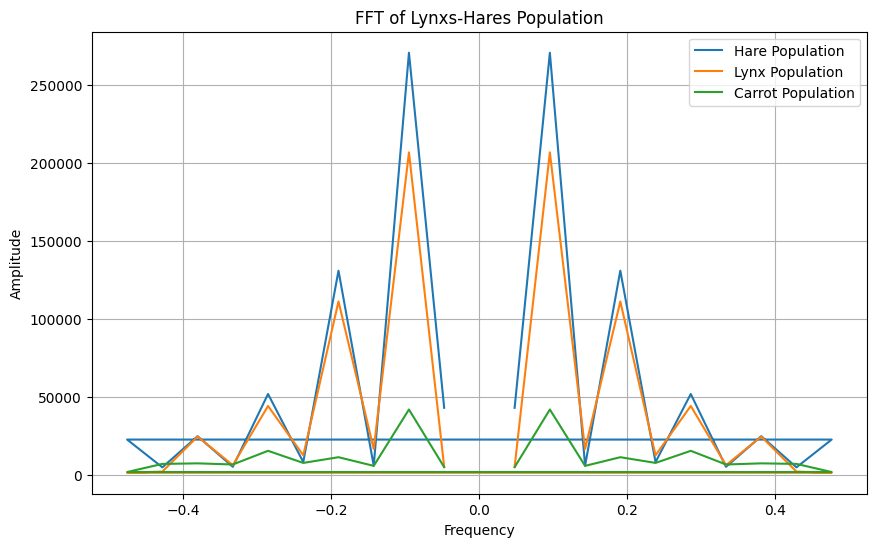

[0.0952381 0.0952381 0.0952381]
Periods of:
Hare: 10.50 years
Lynx: 10.50 years
Carrot: 10.50 years


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Loading the dataset
path = "./data/populations.txt"
data = np.loadtxt(path)

# separating the columns
years = data[:, 0]
populations = data[:, 1:]

# Performing FFT
fft_result = fft(populations, axis=0)
freq = fftfreq(len(years), years[1] - years[0])

# Exclude the zero frequency component
nonzero_freq_mask = freq != 0
freq = freq[nonzero_freq_mask]
fft_result = fft_result[nonzero_freq_mask]

# Finding the peak frequency
dominant_frequency_indices = np.argmax(np.abs(fft_result), axis=0)
#calculating the period
dominant_periods = 1 / np.abs(freq[dominant_frequency_indices])

# Plotting the results
plt.figure(figsize=(10, 6))
for i, species in enumerate(["hare", "lynx", "carrot"]):
    plt.plot(freq, np.abs(fft_result[:, i]), label=f"{species.capitalize()} Population")

plt.title("FFT of Lynxs-Hares Population")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

print(np.abs(freq[dominant_frequency_indices]))
# Printing the periods
print("Periods of:")
for i, species in enumerate(["hare", "lynx", "carrot"]):
    print(f"{species.capitalize()}: {dominant_periods[i]:.2f} years")


4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

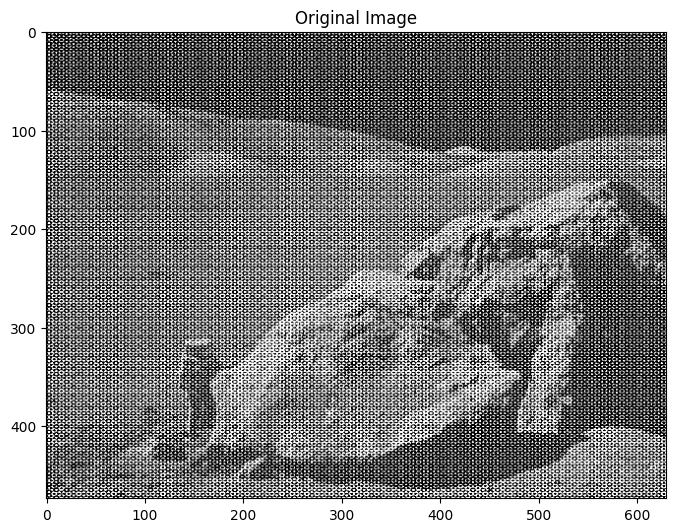

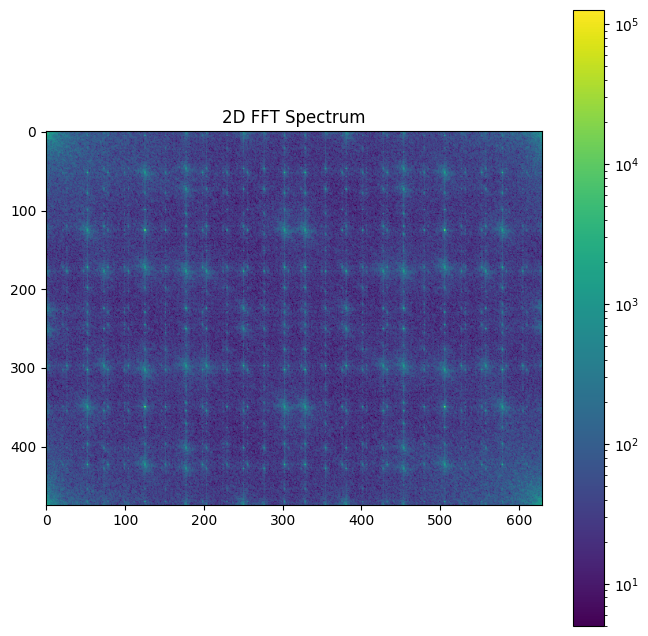

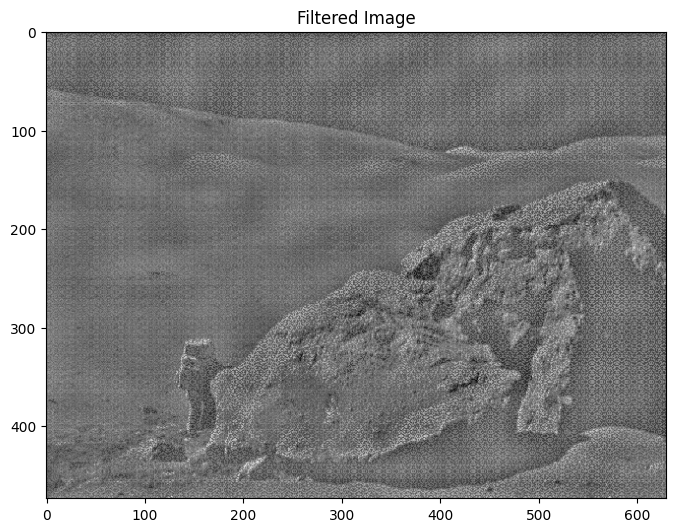

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from matplotlib.colors import LogNorm

# importing the image
image = plt.imread("images/moonlanding.png")

# Plotting the original image
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

# Performing 2D FFT
image_fft = fftpack.fft2(image)

# Plotting the log-scaled spectrum
plt.figure(figsize=(8, 8))
plt.imshow(np.abs(image_fft), norm=LogNorm(vmin=5))
plt.title('2D FFT Spectrum')
plt.colorbar()
plt.show()

# Identify and zero out noise regions in the frequency domain
rows, cols = image.shape
r, c = rows // 2, cols // 2  # Center of the image

# Identifying components with power greater than 10^3 as noise (After inspection)
noise_threshold = 10**3

noise_mask = np.abs(image_fft) > noise_threshold

# Zero out the noise regions
image_fft[noise_mask] = 0

# Perform inverse FFT
image_filtered = fftpack.ifft2(image_fft).real

# Plotting the filtered image
plt.figure(figsize=(8, 8))
plt.imshow(image_filtered, cmap='gray')
plt.title('Filtered Image')
plt.show()
